<a href="https://colab.research.google.com/github/NolanRink/CS4540/blob/main/HW14/P3LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import h5py
from scipy.signal import welch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
if device.type == 'cuda':
    # In Colab this will list the available GPU(s)
    !nvidia-smi -L


Using device: cuda
GPU 0: Tesla T4 (UUID: GPU-8e4fc71a-4385-6c22-9d4d-9153afe893a2)


In [10]:
files = ["Rat08-20130711_017.h5", "Part1SubjectHB10.h5", "Part2SubjectHB13.h5"]
subject_names = ["Rat08_HPC", "SubjectHB10_BLA", "SubjectHB13_BLA"]
data_dict = {}

for subject, filename in zip(subject_names, files):
    segments, labels = [], []
    with h5py.File(filename, 'r') as f:
        fs = f.attrs.get('fs', 1250)  # sampling rate (Hz)
        for state in f.keys():
            lab = 1 if state == "NREM" else 0
            for seg in f[state].values():
                segments.append(seg[()].astype(float))
                labels.append(lab)
    data_dict[subject] = {"segments": segments, "labels": np.array(labels), "fs": fs}
    print(f"{subject}: Loaded {len(segments)} segments")


Rat08_HPC: Loaded 96 segments
SubjectHB10_BLA: Loaded 55 segments
SubjectHB13_BLA: Loaded 41 segments


In [11]:
clip_duration = 5  # seconds
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8,12),
    'beta':  (12,30),
    'gamma': (30,100)
}
processed_data = {}

for subject in subject_names:
    fs = data_dict[subject]["fs"]
    clip_length = int(clip_duration * fs)
    X_raw, X_spectral, y_clips = [], [], []

    for seg, lab in zip(data_dict[subject]["segments"], data_dict[subject]["labels"]):
        if len(seg) < clip_length:
            continue
        num_clips = len(seg) // clip_length
        clips = seg[:num_clips*clip_length].reshape(num_clips, clip_length)

        for clip in clips:
            X_raw.append(clip)
            freqs, psd = welch(clip, fs=fs, nperseg=min(512, clip_length))
            band_feats = [
                np.mean(psd[(freqs >= low) & (freqs <= high)])
                for low, high in bands.values()
            ]
            X_spectral.append(band_feats)
            y_clips.append(lab)

    processed_data[subject] = {
        "X_raw":      np.array(X_raw),
        "X_spectral": np.array(X_spectral),
        "y":          np.array(y_clips),
        "fs":         fs
    }
    print(f"{subject}: {len(X_raw)} clips ({(np.array(y_clips)==1).sum()} NREM)")


<ipython-input-11-12d98c9bb7c7>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  clip_length = int(clip_duration * fs)


Rat08_HPC: 3682 clips (1239 NREM)
SubjectHB10_BLA: 907 clips (330 NREM)
SubjectHB13_BLA: 913 clips (295 NREM)


- Perform stratified splits: 70% train, 15% validation, 15% test (preserving class ratios).  
- Apply z-score normalization separately to the raw time-series (global mean/std) and spectral features (per-feature mean/std).  
- Compute class weights for balanced training due to label imbalance.  


In [12]:
splits = {}
for subject in subject_names:
    Xr, Xs, y = (processed_data[subject][k] for k in ("X_raw","X_spectral","y"))
    Xr_t, Xr_test, Xs_t, Xs_test, y_t, y_test = train_test_split(
        Xr, Xs, y, test_size=0.15, random_state=42, stratify=y
    )
    Xr_train, Xr_val, Xs_train, Xs_val, y_train, y_val = train_test_split(
        Xr_t, Xs_t, y_t, test_size=0.15/0.85, random_state=42, stratify=y_t
    )

    # Raw normalization
    mu_r, std_r = Xr_train.mean(), Xr_train.std()
    Xr_train, Xr_val, Xr_test = (
        (arr - mu_r) / std_r for arr in (Xr_train, Xr_val, Xr_test)
    )

    # Spectral normalization (per-feature)
    mu_s, std_s = Xs_train.mean(0), Xs_train.std(0)
    std_s[std_s == 0] = 1
    Xs_train, Xs_val, Xs_test = (
        (arr - mu_s) / std_s for arr in (Xs_train, Xs_val, Xs_test)
    )

    # Class weights
    cw = class_weight.compute_class_weight('balanced',
          classes=np.unique(y_train), y=y_train)
    cw = torch.tensor(cw, dtype=torch.float32)

    splits[subject] = {
        "Xr_train": Xr_train, "Xr_val": Xr_val, "Xr_test": Xr_test,
        "Xs_train": Xs_train, "Xs_val": Xs_val, "Xs_test": Xs_test,
        "y_train": y_train, "y_val": y_val, "y_test": y_test,
        "class_weights": cw
    }
    print(f"{subject}: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}; cw={cw.numpy()}")


Rat08_HPC: Train=2576, Val=553, Test=553; cw=[0.7536571 1.4855825]
SubjectHB10_BLA: Train=634, Val=136, Test=137; cw=[0.7866005 1.3722944]
SubjectHB13_BLA: Train=639, Val=137, Test=137; cw=[0.7395833 1.5434783]


Convert NumPy arrays to PyTorch tensors and wrap them in `TensorDataset` + `DataLoader` for efficient mini-batch training.  
Raw inputs get shape `[batch, seq_length, 1]`.  
Spectral features are `[batch, num_bands]`.  


In [13]:
batch_size = 64
loaders = {}

for subject in subject_names:
    Xr_tr = torch.tensor(splits[subject]["Xr_train"], dtype=torch.float32).unsqueeze(-1)
    Xr_va = torch.tensor(splits[subject]["Xr_val"],   dtype=torch.float32).unsqueeze(-1)
    Xr_te = torch.tensor(splits[subject]["Xr_test"],  dtype=torch.float32).unsqueeze(-1)
    Xs_tr = torch.tensor(splits[subject]["Xs_train"], dtype=torch.float32)
    Xs_va = torch.tensor(splits[subject]["Xs_val"],   dtype=torch.float32)
    Xs_te = torch.tensor(splits[subject]["Xs_test"],  dtype=torch.float32)
    y_tr  = torch.tensor(splits[subject]["y_train"],  dtype=torch.long)
    y_va  = torch.tensor(splits[subject]["y_val"],    dtype=torch.long)
    y_te  = torch.tensor(splits[subject]["y_test"],   dtype=torch.long)

    train_ds = TensorDataset(Xr_tr, Xs_tr, y_tr)
    val_ds   = TensorDataset(Xr_va, Xs_va, y_va)
    test_ds  = TensorDataset(Xr_te, Xs_te, y_te)

    loaders[subject] = {
        'train': DataLoader(train_ds, batch_size, shuffle=True),
        'val':   DataLoader(val_ds,   batch_size, shuffle=False),
        'test':  DataLoader(test_ds,  batch_size, shuffle=False)
    }


Define a bidirectional, multi-layer LSTM with an attention mechanism over time.  
Also create a small MLP to encode the 5 spectral band features.  
Finally, fuse both representations and classify into 2 classes.  


In [14]:
class EnhancedSleepLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2,
                 dropout=0.3, num_spectral_features=5):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers>1 else 0,
            batch_first=True, bidirectional=True
        )
        # Attention over sequence outputs
        self.attention = nn.Sequential(
            nn.Linear(hidden_size*2, 1), nn.Tanh()
        )
        # Spectral encoder MLP
        self.spectral_encoder = nn.Sequential(
            nn.Linear(num_spectral_features, hidden_size),
            nn.ReLU(), nn.Dropout(dropout)
        )
        # Final fusion & classifier
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*2 + hidden_size, hidden_size),
            nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden_size, 2)
        )

    def forward(self, x_raw, x_spec):
        lstm_out, _ = self.lstm(x_raw)                        # [B, T, H*2]
        attn_w = torch.softmax(self.attention(lstm_out), dim=1)  # [B, T, 1]
        context = (lstm_out * attn_w).sum(dim=1)              # [B, H*2]
        spec_enc = self.spectral_encoder(x_spec)              # [B, H]
        combined = torch.cat([context, spec_enc], dim=1)      # [B, H*3]
        return self.fc(combined)                              # [B, 2]


Train with:  
- Adam optimizer + weight decay  
- `ReduceLROnPlateau` scheduler on validation accuracy  
- Class-weighted cross-entropy to handle imbalance  
- Mixed-precision (`GradScaler`) for GPU speed  
- Early stopping based on validation F1 (focus on NREM class)  


In [15]:
def train_model(subj, model, train_loader, val_loader, class_weights,
                epochs=100, lr=1e-3, patience=10):
    model.to(device)
    cw = class_weights.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, verbose=True
    )
    criterion = nn.CrossEntropyLoss(weight=cw).to(device)
    scaler = torch.cuda.amp.GradScaler()

    best_f1, no_improve = 0, 0
    history = {'train_acc': [], 'val_acc': []}

    for epoch in range(1, epochs+1):
        # Training
        model.train()
        correct_tr = total_tr = 0
        loss_tr = 0
        for Xr, Xs, y in train_loader:
            Xr, Xs, y = Xr.to(device), Xs.to(device), y.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                out = model(Xr, Xs)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            loss_tr += loss.item()
            preds = out.argmax(1)
            correct_tr += (preds == y).sum().item()
            total_tr += y.size(0)
        train_acc = correct_tr / total_tr
        loss_tr /= len(train_loader)

        # Validation
        model.eval()
        correct_va = total_va = 0
        loss_va = 0
        all_p, all_l = [], []
        with torch.no_grad():
            for Xr, Xs, y in val_loader:
                Xr, Xs, y = Xr.to(device), Xs.to(device), y.to(device)
                out = model(Xr, Xs)
                loss = criterion(out, y)
                loss_va += loss.item()
                preds = out.argmax(1)
                all_p.extend(preds.cpu().numpy())
                all_l.extend(y.cpu().numpy())
                correct_va += (preds == y).sum().item()
                total_va += y.size(0)
        val_acc = correct_va / total_va
        loss_va /= len(val_loader)

        # Compute F1 for NREM class
        cm = confusion_matrix(all_l, all_p)
        if cm.shape == (2,2):
            prec = cm[1,1] / (cm[1,1]+cm[0,1]) if cm[1,1]+cm[0,1]>0 else 0
            rec  = cm[1,1] / (cm[1,1]+cm[1,0]) if cm[1,1]+cm[1,0]>0 else 0
            f1   = 2*prec*rec/(prec+rec) if prec+rec>0 else 0
        else:
            f1 = 0

        scheduler.step(val_acc)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"{subj} E{epoch}/{epochs} "
              f"TrLoss:{loss_tr:.4f} VaLoss:{loss_va:.4f} "
              f"TrAcc:{train_acc*100:.1f}% VaAcc:{val_acc*100:.1f}% F1:{f1:.4f}")

        if f1 > best_f1:
            best_f1, no_improve = f1, 0
            torch.save(model.state_dict(), f"{subj}_best.pt")
            print(" ✓ saved")
        else:
            no_improve += 1
            if no_improve >= patience:
                print(" Early stopping.")
                break

    model.load_state_dict(torch.load(f"{subj}_best.pt"))
    return history, model


For each subject:  
1. Initialize & train the model.  
2. Evaluate on the test set: print accuracy, confusion matrix, classification report.  
3. Plot training vs validation accuracy curves and the test confusion matrix.  



=== Rat08_HPC ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-15-893625c7e94b>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E1/100 TrLoss:0.5519 VaLoss:0.3779 TrAcc:81.2% VaAcc:88.8% F1:0.8368
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E2/100 TrLoss:0.3415 VaLoss:0.2500 TrAcc:88.9% VaAcc:92.6% F1:0.8918
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E3/100 TrLoss:0.2668 VaLoss:0.2188 TrAcc:90.4% VaAcc:92.4% F1:0.8901


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E4/100 TrLoss:0.2320 VaLoss:0.2051 TrAcc:91.5% VaAcc:92.2% F1:0.8900


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E5/100 TrLoss:0.2275 VaLoss:0.2103 TrAcc:90.6% VaAcc:92.0% F1:0.8824


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E6/100 TrLoss:0.2247 VaLoss:0.1962 TrAcc:91.1% VaAcc:92.0% F1:0.8883


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E7/100 TrLoss:0.2157 VaLoss:0.1943 TrAcc:91.5% VaAcc:91.7% F1:0.8832


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E8/100 TrLoss:0.2162 VaLoss:0.1871 TrAcc:91.3% VaAcc:92.4% F1:0.8918


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E9/100 TrLoss:0.2144 VaLoss:0.1871 TrAcc:91.7% VaAcc:92.6% F1:0.8951
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E10/100 TrLoss:0.2209 VaLoss:0.1829 TrAcc:91.7% VaAcc:92.4% F1:0.8929


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E11/100 TrLoss:0.2139 VaLoss:0.1850 TrAcc:91.8% VaAcc:92.0% F1:0.8889


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E12/100 TrLoss:0.2031 VaLoss:0.1791 TrAcc:92.1% VaAcc:92.8% F1:0.8980
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E13/100 TrLoss:0.1959 VaLoss:0.1744 TrAcc:92.5% VaAcc:93.1% F1:0.9026
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E14/100 TrLoss:0.1923 VaLoss:0.1734 TrAcc:92.4% VaAcc:91.9% F1:0.8866


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E15/100 TrLoss:0.1910 VaLoss:0.1707 TrAcc:92.5% VaAcc:92.6% F1:0.8962


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E16/100 TrLoss:0.1917 VaLoss:0.1682 TrAcc:92.5% VaAcc:92.9% F1:0.9008


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E17/100 TrLoss:0.1855 VaLoss:0.1675 TrAcc:92.3% VaAcc:92.6% F1:0.8967


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E18/100 TrLoss:0.1932 VaLoss:0.1663 TrAcc:92.5% VaAcc:92.2% F1:0.8928


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E19/100 TrLoss:0.1795 VaLoss:0.1613 TrAcc:92.7% VaAcc:93.9% F1:0.9128
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E20/100 TrLoss:0.1778 VaLoss:0.1687 TrAcc:92.7% VaAcc:93.3% F1:0.9034


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E21/100 TrLoss:0.1795 VaLoss:0.1646 TrAcc:92.8% VaAcc:92.2% F1:0.8933


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E22/100 TrLoss:0.1754 VaLoss:0.1595 TrAcc:92.7% VaAcc:92.8% F1:0.8990


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E23/100 TrLoss:0.1785 VaLoss:0.1646 TrAcc:92.8% VaAcc:92.4% F1:0.8955


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E24/100 TrLoss:0.1870 VaLoss:0.1556 TrAcc:92.6% VaAcc:92.9% F1:0.9018


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E25/100 TrLoss:0.1723 VaLoss:0.1549 TrAcc:93.2% VaAcc:93.3% F1:0.9068


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E26/100 TrLoss:0.1740 VaLoss:0.1576 TrAcc:93.1% VaAcc:92.8% F1:0.9005


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E27/100 TrLoss:0.1716 VaLoss:0.1606 TrAcc:93.0% VaAcc:92.4% F1:0.8955


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E28/100 TrLoss:0.1736 VaLoss:0.1515 TrAcc:93.1% VaAcc:93.5% F1:0.9086


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Rat08_HPC E29/100 TrLoss:0.1750 VaLoss:0.1477 TrAcc:92.7% VaAcc:93.3% F1:0.9063
 Early stopping.
Test Acc: 92.95%
 [[343  24]
 [ 15 171]]
              precision    recall  f1-score   support

        WAKE       0.96      0.93      0.95       367
        NREM       0.88      0.92      0.90       186

    accuracy                           0.93       553
   macro avg       0.92      0.93      0.92       553
weighted avg       0.93      0.93      0.93       553



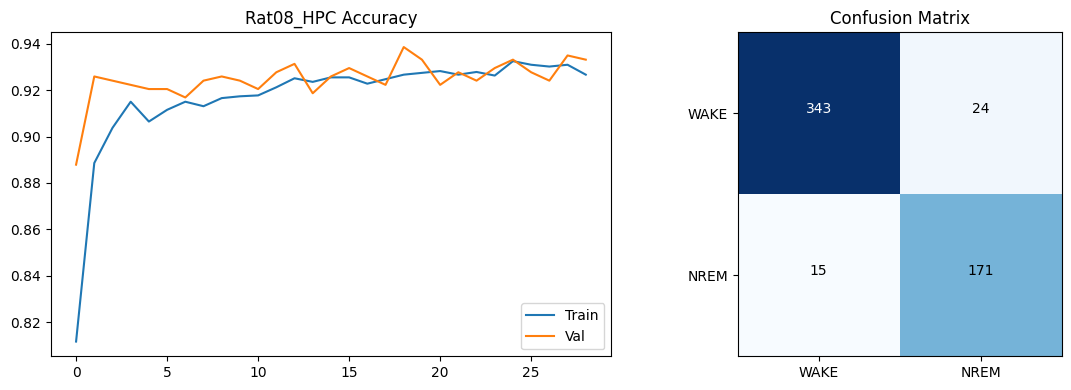


=== SubjectHB10_BLA ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-15-893625c7e94b>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E1/100 TrLoss:0.6295 VaLoss:0.5303 TrAcc:66.2% VaAcc:98.5% F1:0.9800
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E2/100 TrLoss:0.4496 VaLoss:0.3369 TrAcc:98.1% VaAcc:98.5% F1:0.9800


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E3/100 TrLoss:0.2713 VaLoss:0.1765 TrAcc:98.3% VaAcc:97.8% F1:0.9703


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E4/100 TrLoss:0.1425 VaLoss:0.0843 TrAcc:98.7% VaAcc:99.3% F1:0.9899
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E5/100 TrLoss:0.0806 VaLoss:0.0419 TrAcc:99.2% VaAcc:99.3% F1:0.9899


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E6/100 TrLoss:0.0545 VaLoss:0.0245 TrAcc:99.2% VaAcc:100.0% F1:1.0000
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E7/100 TrLoss:0.0424 VaLoss:0.0173 TrAcc:99.5% VaAcc:100.0% F1:1.0000


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E8/100 TrLoss:0.0241 VaLoss:0.0113 TrAcc:99.8% VaAcc:100.0% F1:1.0000


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E9/100 TrLoss:0.0143 VaLoss:0.0086 TrAcc:100.0% VaAcc:100.0% F1:1.0000


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E10/100 TrLoss:0.0128 VaLoss:0.0072 TrAcc:100.0% VaAcc:100.0% F1:1.0000


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E11/100 TrLoss:0.0126 VaLoss:0.0077 TrAcc:100.0% VaAcc:100.0% F1:1.0000


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E12/100 TrLoss:0.0096 VaLoss:0.0044 TrAcc:100.0% VaAcc:100.0% F1:1.0000


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E13/100 TrLoss:0.0114 VaLoss:0.0040 TrAcc:99.8% VaAcc:100.0% F1:1.0000


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E14/100 TrLoss:0.0083 VaLoss:0.0041 TrAcc:99.8% VaAcc:100.0% F1:1.0000


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E15/100 TrLoss:0.0089 VaLoss:0.0055 TrAcc:99.8% VaAcc:100.0% F1:1.0000


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB10_BLA E16/100 TrLoss:0.0102 VaLoss:0.0026 TrAcc:99.7% VaAcc:100.0% F1:1.0000
 Early stopping.
Test Acc: 100.00%
 [[87  0]
 [ 0 50]]
              precision    recall  f1-score   support

        WAKE       1.00      1.00      1.00        87
        NREM       1.00      1.00      1.00        50

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137



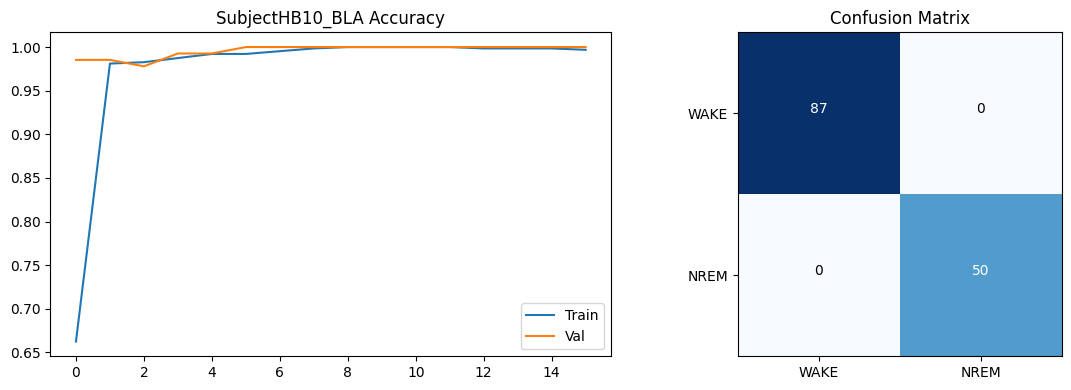


=== SubjectHB13_BLA ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-15-893625c7e94b>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E1/100 TrLoss:0.6064 VaLoss:0.5240 TrAcc:87.5% VaAcc:91.2% F1:0.8696
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E2/100 TrLoss:0.4541 VaLoss:0.3714 TrAcc:93.0% VaAcc:89.1% F1:0.8421


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E3/100 TrLoss:0.3024 VaLoss:0.2613 TrAcc:93.1% VaAcc:89.1% F1:0.8421


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E4/100 TrLoss:0.1992 VaLoss:0.1965 TrAcc:94.7% VaAcc:89.8% F1:0.8542


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E5/100 TrLoss:0.1516 VaLoss:0.1742 TrAcc:94.4% VaAcc:91.2% F1:0.8723
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E6/100 TrLoss:0.1140 VaLoss:0.1600 TrAcc:96.7% VaAcc:92.7% F1:0.8913
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E7/100 TrLoss:0.0883 VaLoss:0.1520 TrAcc:97.5% VaAcc:92.7% F1:0.8913


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E8/100 TrLoss:0.0858 VaLoss:0.1309 TrAcc:97.3% VaAcc:92.7% F1:0.8958
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E9/100 TrLoss:0.0635 VaLoss:0.1456 TrAcc:97.7% VaAcc:93.4% F1:0.9011
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E10/100 TrLoss:0.0539 VaLoss:0.1371 TrAcc:98.7% VaAcc:94.2% F1:0.9149
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E11/100 TrLoss:0.0511 VaLoss:0.1342 TrAcc:98.1% VaAcc:94.2% F1:0.9149


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E12/100 TrLoss:0.0531 VaLoss:0.1439 TrAcc:98.1% VaAcc:94.9% F1:0.9247
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E13/100 TrLoss:0.0391 VaLoss:0.1272 TrAcc:98.6% VaAcc:94.2% F1:0.9149


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E14/100 TrLoss:0.0456 VaLoss:0.1490 TrAcc:98.7% VaAcc:95.6% F1:0.9348
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E15/100 TrLoss:0.0422 VaLoss:0.1322 TrAcc:98.7% VaAcc:94.9% F1:0.9247


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E16/100 TrLoss:0.0419 VaLoss:0.1322 TrAcc:98.6% VaAcc:94.9% F1:0.9247


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E17/100 TrLoss:0.0432 VaLoss:0.1404 TrAcc:98.3% VaAcc:95.6% F1:0.9348


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E18/100 TrLoss:0.0367 VaLoss:0.1109 TrAcc:98.9% VaAcc:94.9% F1:0.9247


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E19/100 TrLoss:0.0394 VaLoss:0.1153 TrAcc:98.6% VaAcc:94.9% F1:0.9247


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E20/100 TrLoss:0.0331 VaLoss:0.1156 TrAcc:99.1% VaAcc:97.1% F1:0.9556
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E21/100 TrLoss:0.0364 VaLoss:0.0857 TrAcc:98.9% VaAcc:95.6% F1:0.9362


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E22/100 TrLoss:0.0266 VaLoss:0.0974 TrAcc:99.1% VaAcc:96.4% F1:0.9451


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E23/100 TrLoss:0.0321 VaLoss:0.0913 TrAcc:99.1% VaAcc:95.6% F1:0.9348


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E24/100 TrLoss:0.0202 VaLoss:0.0907 TrAcc:99.2% VaAcc:96.4% F1:0.9451


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E25/100 TrLoss:0.0345 VaLoss:0.0703 TrAcc:99.1% VaAcc:96.4% F1:0.9462


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E26/100 TrLoss:0.0272 VaLoss:0.0703 TrAcc:99.4% VaAcc:96.4% F1:0.9462


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E27/100 TrLoss:0.0336 VaLoss:0.0757 TrAcc:98.9% VaAcc:97.1% F1:0.9556


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E28/100 TrLoss:0.0253 VaLoss:0.0700 TrAcc:98.9% VaAcc:96.4% F1:0.9462


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E29/100 TrLoss:0.0243 VaLoss:0.0615 TrAcc:99.2% VaAcc:97.1% F1:0.9565
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E30/100 TrLoss:0.0247 VaLoss:0.0748 TrAcc:99.2% VaAcc:97.1% F1:0.9556


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E31/100 TrLoss:0.0264 VaLoss:0.0541 TrAcc:99.4% VaAcc:95.6% F1:0.9362


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E32/100 TrLoss:0.0277 VaLoss:0.0545 TrAcc:99.4% VaAcc:95.6% F1:0.9362


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E33/100 TrLoss:0.0303 VaLoss:0.0560 TrAcc:98.4% VaAcc:97.1% F1:0.9565


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E34/100 TrLoss:0.0220 VaLoss:0.0568 TrAcc:99.8% VaAcc:97.1% F1:0.9565


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E35/100 TrLoss:0.0138 VaLoss:0.0539 TrAcc:99.7% VaAcc:95.6% F1:0.9362


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E36/100 TrLoss:0.0208 VaLoss:0.0518 TrAcc:99.4% VaAcc:97.8% F1:0.9670
 ✓ saved


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E37/100 TrLoss:0.0234 VaLoss:0.0474 TrAcc:99.1% VaAcc:97.1% F1:0.9565


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E38/100 TrLoss:0.0197 VaLoss:0.0454 TrAcc:99.4% VaAcc:97.1% F1:0.9565


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E39/100 TrLoss:0.0180 VaLoss:0.0435 TrAcc:99.4% VaAcc:97.1% F1:0.9565


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E40/100 TrLoss:0.0149 VaLoss:0.0486 TrAcc:99.5% VaAcc:97.8% F1:0.9670


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E41/100 TrLoss:0.0184 VaLoss:0.0488 TrAcc:99.5% VaAcc:97.8% F1:0.9670


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E42/100 TrLoss:0.0225 VaLoss:0.0416 TrAcc:99.2% VaAcc:97.8% F1:0.9670


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E43/100 TrLoss:0.0162 VaLoss:0.0425 TrAcc:99.4% VaAcc:95.6% F1:0.9362


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E44/100 TrLoss:0.0126 VaLoss:0.0410 TrAcc:99.7% VaAcc:97.1% F1:0.9565


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E45/100 TrLoss:0.0204 VaLoss:0.0412 TrAcc:99.1% VaAcc:97.1% F1:0.9565


<ipython-input-15-893625c7e94b>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


SubjectHB13_BLA E46/100 TrLoss:0.0197 VaLoss:0.0421 TrAcc:99.4% VaAcc:97.8% F1:0.9670
 Early stopping.
Test Acc: 98.54%
 [[91  2]
 [ 0 44]]
              precision    recall  f1-score   support

        WAKE       1.00      0.98      0.99        93
        NREM       0.96      1.00      0.98        44

    accuracy                           0.99       137
   macro avg       0.98      0.99      0.98       137
weighted avg       0.99      0.99      0.99       137



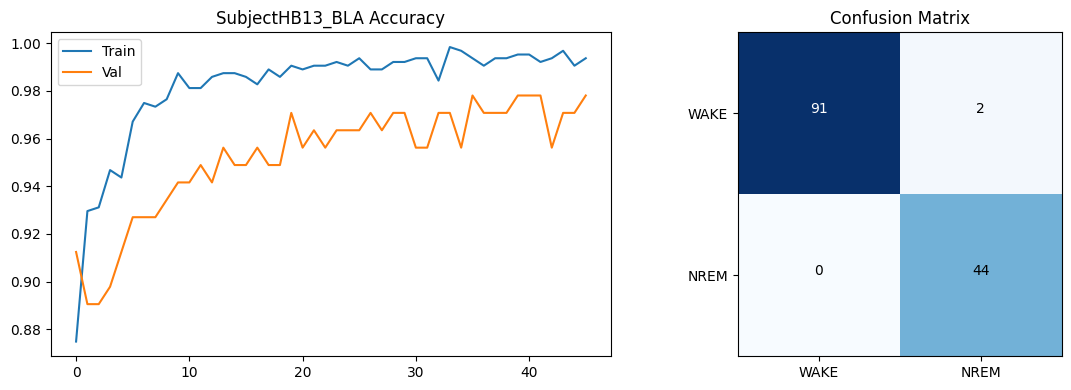

In [16]:
models, histories = {}, {}

for subj in subject_names:
    print(f"\n=== {subj} ===")
    model = EnhancedSleepLSTM(
        hidden_size=64, num_layers=2,
        dropout=0.3, num_spectral_features=len(bands)
    )
    history, best_model = train_model(
        subj, model,
        loaders[subj]['train'], loaders[subj]['val'],
        splits[subj]['class_weights'],
        epochs=100, lr=1e-3, patience=10
    )
    models[subj] = best_model
    histories[subj] = history

    # Test evaluation
    all_p, all_l = [], []
    with torch.no_grad():
        for Xr, Xs, y in loaders[subj]['test']:
            Xr, Xs = Xr.to(device), Xs.to(device)
            out = best_model(Xr, Xs)
            all_p.extend(out.argmax(1).cpu().numpy())
            all_l.extend(y.numpy())
    all_p, all_l = np.array(all_p), np.array(all_l)
    acc = (all_p == all_l).mean() * 100
    cm = confusion_matrix(all_l, all_p)
    print(f"Test Acc: {acc:.2f}%\n", cm)
    print(classification_report(all_l, all_p, target_names=['WAKE','NREM']))

    # Plot
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(histories[subj]['train_acc'], label='Train')
    plt.plot(histories[subj]['val_acc'],   label='Val')
    plt.title(f"{subj} Accuracy"); plt.legend()
    plt.subplot(1,2,2)
    plt.imshow(cm, cmap='Blues'); plt.title("Confusion Matrix")
    for i in range(2):
        for j in range(2):
            plt.text(j,i,cm[i,j], ha='center',
                     color='white' if cm[i,j]>cm.max()/2 else 'black')
    plt.xticks([0,1],['WAKE','NREM']); plt.yticks([0,1],['WAKE','NREM'])
    plt.tight_layout(); plt.show()
